## Compare UI Ekman and UI SST

In [1]:
## import packages
%matplotlib inline
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib
import cartopy.crs as ccrs
import glob
import os
import my_functions
import datetime

In [2]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('Surface_stress/Turbulent_mean/Turbulent_mean_weekly.nc')
UI_SST = UI_SST = xr.open_dataset('CoastNET_SST_UI.nc')
LSM = xr.open_dataset('ERA5_land_sea_mask.nc')

In [151]:
## preprocessing steps
# add the land sea mask to the MTSS dataset
MTSS['lsm'] = LSM.lsm

# calculate upwelling index from wind stress dataset -> use my upwelling function (from my_functions.py)
UI_Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss, MTSS.mntss)

# calculate meridional mean (1D Portuguese upwelling index), does meridional mean of UI by default
UI_Ek = my_functions.calc_meridional_mean(UI_Ek)
UI_SST = my_functions.calc_meridional_mean(UI_SST)

# create subset of summer months, June-September (week 22-39), subsets week 22-39 by default
UI_Ek_summer = my_functions.subset_summer(UI_Ek)
UI_SST_summer = my_functions.subset_summer(UI_SST)

## Plot 

### Single Point near Lisbon

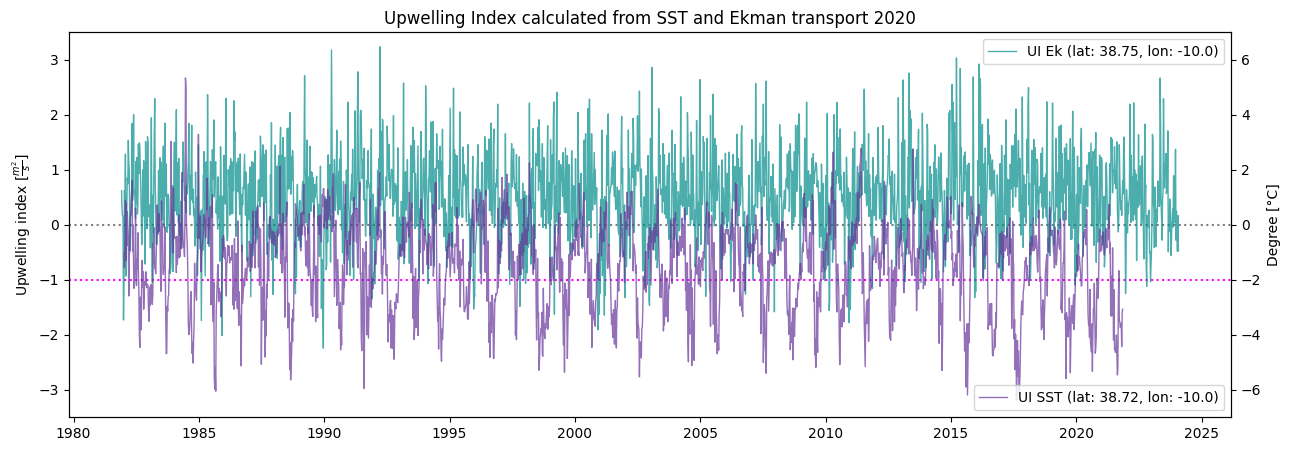

In [5]:
## compare UIs 
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(-1, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time, UI_Ek.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 1)
# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time, UI_SST.UI.sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 1)

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-3.5, 3.5)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-7,7)
ax2.legend(loc = 4)

plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr]');

Text(0.5, 0, 'Time [yr-m]')

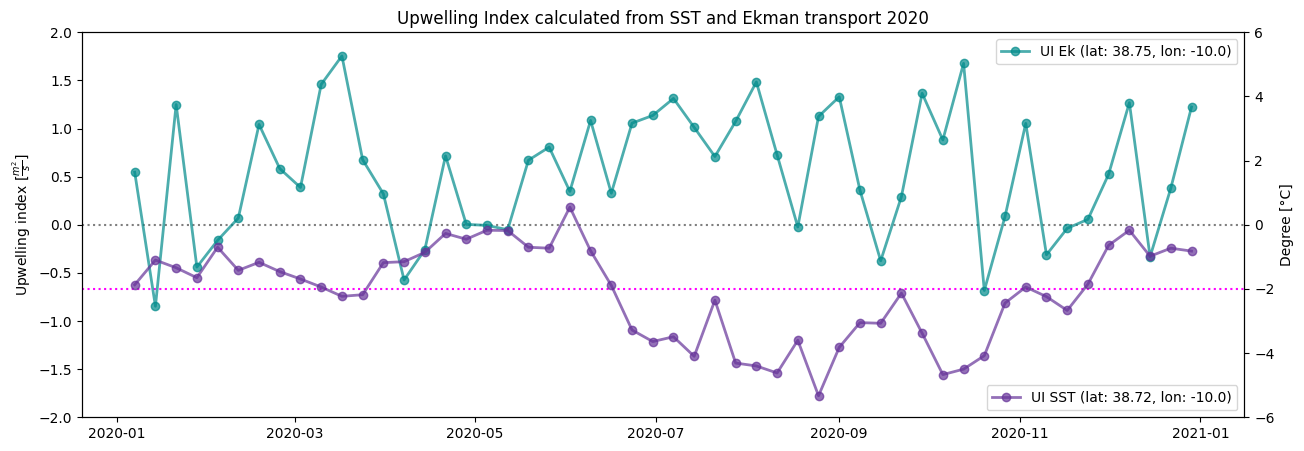

In [6]:
# compare only 1 year of data
fig, ax1 = plt.subplots(figsize=(15,5))

# 0 line
plt.axhline(0, color = 'k', linestyle = ':', alpha = 0.5);
# -2°C line (as signifier for an upwelling event, -2/3 on primary axis = -2 on secondary)
plt.axhline(-2/3, color = 'magenta', linestyle = ':')

# primary axis
ax1.plot(UI_Ek.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_Ek.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI Ek (lat: {UI_Ek.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_Ek.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'darkcyan', alpha = 0.7, linewidth = 2, marker = 'o')

# secondary axis 
ax2 = ax1.twinx()
ax2.plot(UI_SST.time.sel(time = slice ("2020-01-01", "2020-12-31")), UI_SST.UI.sel(time = slice ("2020-01-01", "2020-12-31")).sel(lat = 38.7, lon = -10, method = 'nearest'), 
         label = f"UI SST (lat: {UI_SST.lat.sel(lat = 38.7, method = 'nearest').values.round(2)}, lon: {UI_SST.lon.sel(lon = -10, method = 'nearest').values.round(2)})",
         color = 'rebeccapurple', alpha = 0.7, linewidth = 2, marker = 'o')

# layout 
ax1.set_ylabel(r'Upwelling index [$\frac{m^{2}}{s}$]');
ax1.set_ylim(-2, 2)
ax1.legend(loc = 0)

ax2.set_ylabel('Degree [°C]')
ax2.set_ylim(-6,6)
ax2.legend(loc = 4)

plt.title('Upwelling Index calculated from SST and Ekman transport 2020')
plt.xlabel('Time [yr-m]')


### Overview Lat over Time

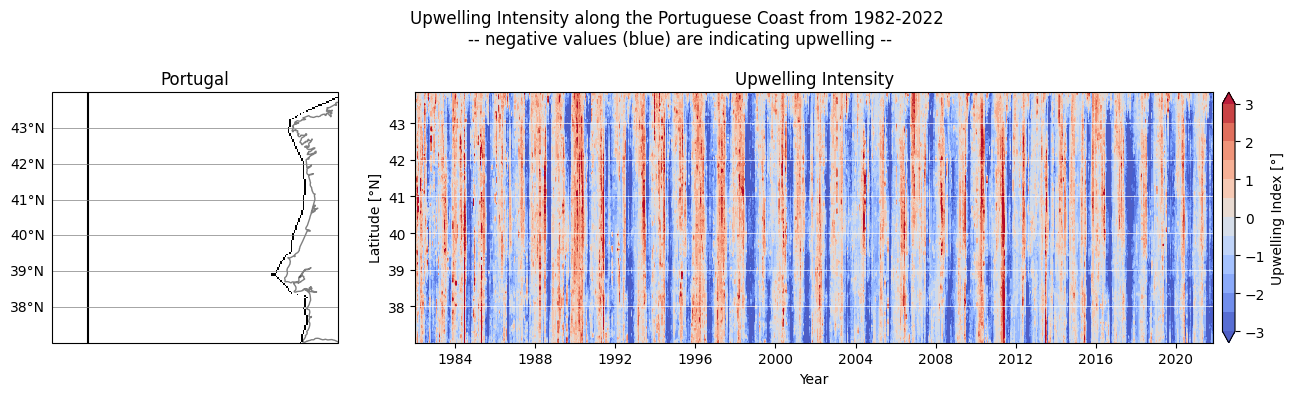

In [4]:
# plot UI SST as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot UI SST
#cols = matplotlib.colors.LinearSegmentedColormap.from_list('',['darkcyan','deeppink']) # attempt at creating own colorbar
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm', levels = np.arange(-3, 3.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = f'Upwelling Index [°]', ticks = np.arange(-3, 4, 1));

fig.suptitle('Upwelling Intensity along the Portuguese Coast from 1982-2022 \n-- negative values (blue) are indicating upwelling --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_SST.png', dpi = 300)

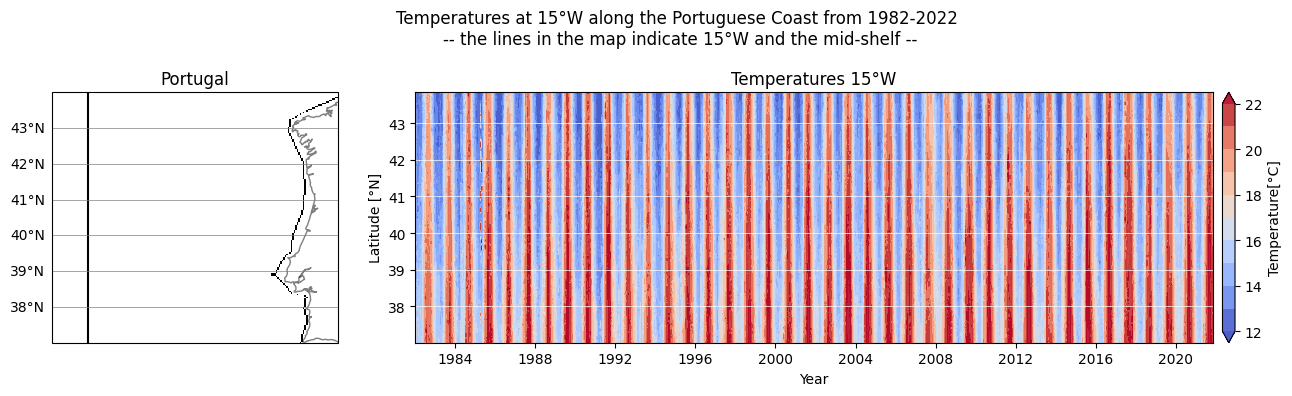

In [5]:
# plot SST Toff15 as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())

lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')

# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, (UI_SST.Toff15W.sel(lon = - 15, method = 'nearest').transpose() - 273.15), 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperatures 15°W')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature[°C]');

fig.suptitle('Temperatures at 15°W along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_15W.png', dpi = 300)

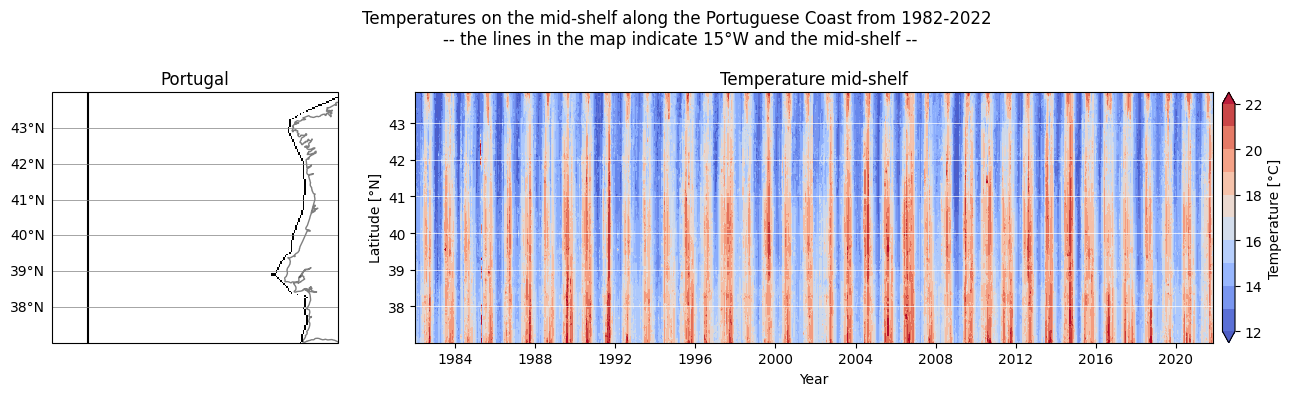

In [6]:
# plot SST Tmid as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,3])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-16, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# add mid-shelf and 15°W line
UI_SST.Tmid.isel(time = 0).transpose().plot(ax = ax1, cmap = 'Greys_r', levels = np.arange(285, 1000, 1), extend = 'both', 
                                            add_colorbar=False, transform = ccrs.PlateCarree())
lon1, lat1 = ccrs.PlateCarree().transform_point(-15 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-15, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1.5)

ax1.set_title('Portugal')


# plot temperatures
im2 = ax2.contourf(UI_SST.UI.time.values, UI_SST.lat.values, UI_SST.Tmid.sum(dim = 'lon').transpose() - 273.15, 
             cmap = 'coolwarm', levels = np.arange(12, 23, 1), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Temperature mid-shelf')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = 'Temperature [°C]');

fig.suptitle('Temperatures on the mid-shelf along the Portuguese Coast from 1982-2022 \n-- the lines in the map indicate 15°W and the mid-shelf --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_T_mid.png', dpi = 300)

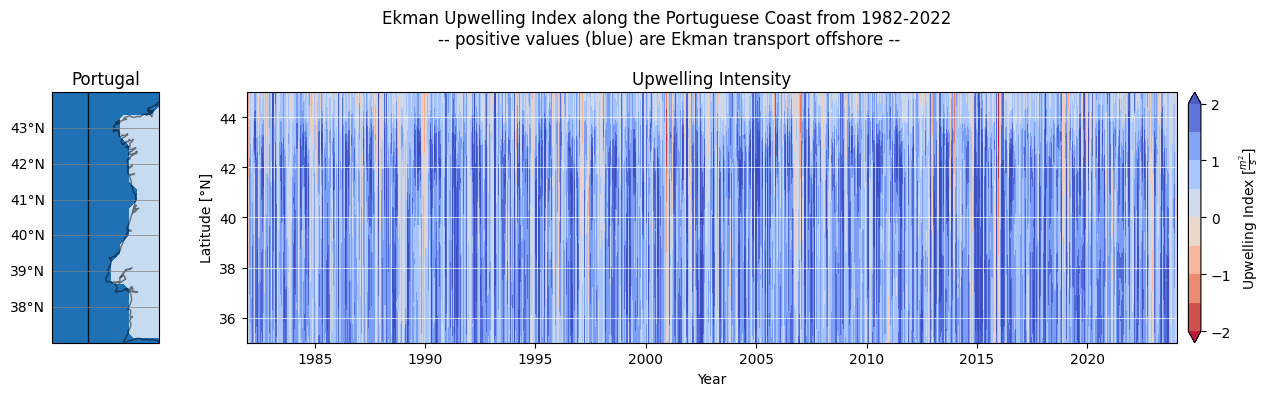

In [7]:
# plot UI Ek as a function of time

# set up figure
fig = plt.figure(figsize = (14,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,7])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-11, -8, 44, 37])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True

# plot ERA5 land mask
ax1.contourf(UI_Ek.lon, UI_Ek.lat, UI_Ek.lsm, cmap = 'Blues', transform = ccrs.PlateCarree())

# plot 10°W line (line I am plotting my UI Ek for)
lon1, lat1 = ccrs.PlateCarree().transform_point(-10 , 37, ccrs.Geodetic())
lon2, lat2 = ccrs.PlateCarree().transform_point(-10, 44, ccrs.Geodetic())
ax1.plot([lon1, lon2], [lat1, lat2], transform = ccrs.PlateCarree(), color='black', linewidth=1, alpha = 0.8)

ax1.set_title('Portugal')

# plot UI Ek
im2 = ax2.contourf(UI_Ek.time.values, UI_Ek.lat.values, UI_Ek.UI.sel(lon = - 10, method = 'nearest').transpose(), 
             cmap = 'coolwarm_r', levels = np.arange(-2, 2.5, 0.5), extend = 'both', alpha = 0.9)
ax2.set_ylabel('Latitude [°N]')
ax2.set_xlabel('Year');
ax2.set_title('Upwelling Intensity')
ax2.grid(color = 'white', linewidth = 0.5, axis = 'y')
plt.colorbar(im2, pad = 0.01, label = r'Upwelling Index [$\frac{m^2}{s}$]', ticks = np.arange(-2, 3, 1));

fig.suptitle('Ekman Upwelling Index along the Portuguese Coast from 1982-2022 \n-- positive values (blue) are Ekman transport offshore --')
fig.tight_layout()
fig.savefig('../Iberian_Coast_Upwelling/Figures/Overview_UI_Ekman.png', dpi = 300)

## Trends

Text(0.5, 1.0, 'Mean Summer (Jun-Sep) Upwelling trend Ek')

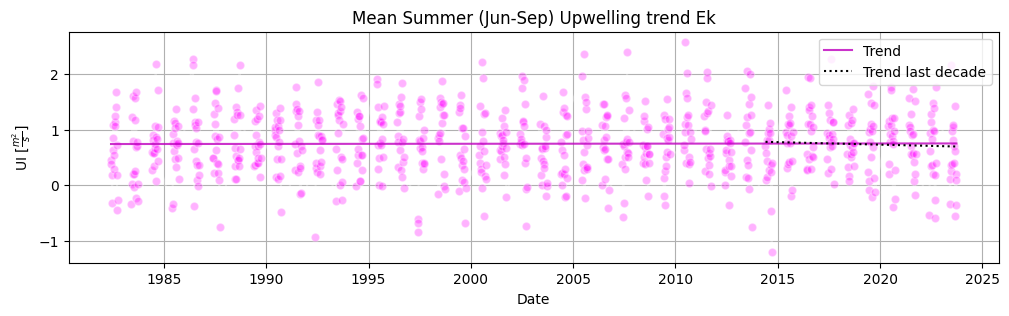

In [75]:
# get values for the trend line analysis
fig = plt.figure(figsize = (12, 3))

x_dates = UI_Ek_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]

y = UI_Ek_summer.UI_mean

# calculate a fit line
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
fit_10 = np.poly1d(trend_10)

# general plot again
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "m-", alpha = 0.8, label = 'Trend') 

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer (Jun-Sep) Upwelling trend Ek')

Text(0.5, 1.0, 'Mean Summer Upwelling trend UI')

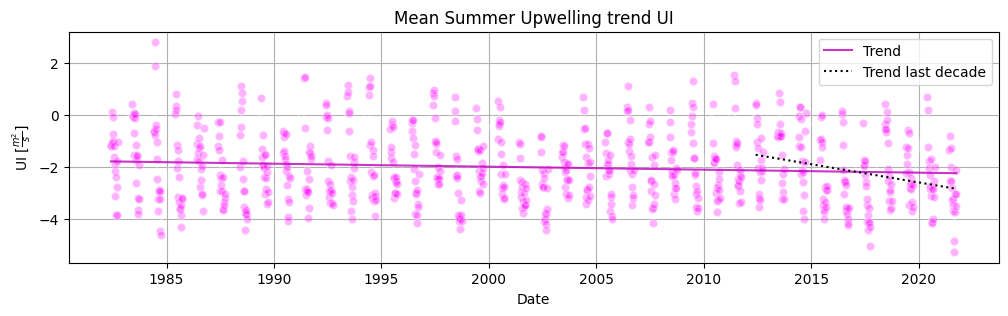

In [68]:
# get values for the trend line analysis
fig = plt.figure(figsize = (12, 3))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]

y = UI_SST_summer.UI_mean

# calculate a fit line
trend = np.polyfit(x_num, y, 1)
fit = np.poly1d(trend)

# calculate fitline only for past decade
trend_10 = np.polyfit(x_num_10, y[-180:-1], 1)
fit_10 = np.poly1d(trend_10)

# general plot 
plt.plot(x_dates, y, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white')
plt.xlabel('Date')
plt.ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
plt.plot(dates.num2date(x_fit), fit(x_fit), "m-", alpha = 0.8, label = 'Trend')

# last 10 years
x_fit_10 = np.linspace(x_num_10.min(), x_num_10.max())
plt.plot(dates.num2date(x_fit_10), fit_10(x_fit_10), "k:", alpha = 1, label = 'Trend last decade') 

plt.legend()
plt.grid()
plt.title('Mean Summer Upwelling trend UI')

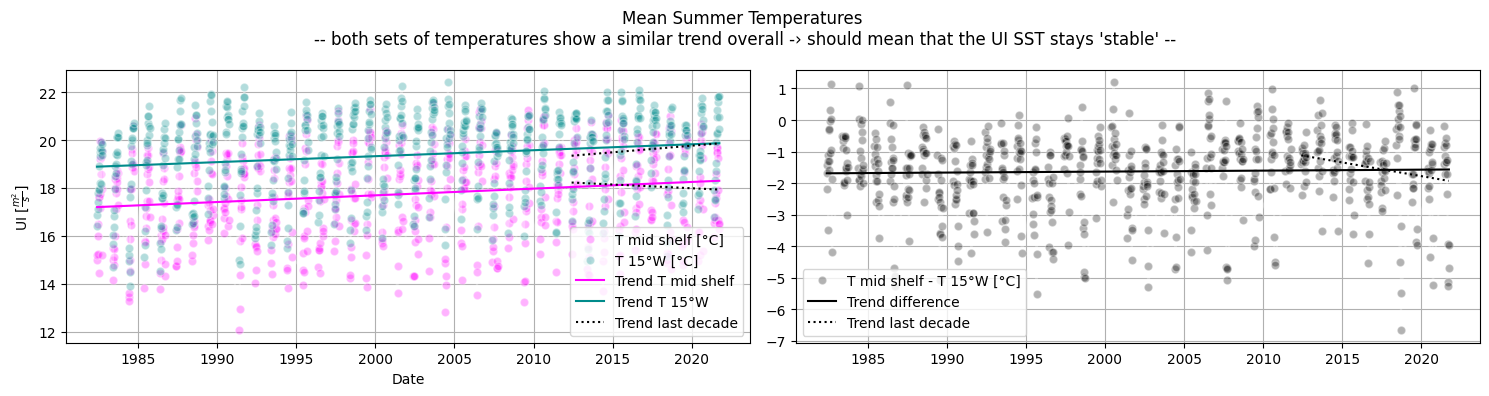

In [72]:
# get values for the trend line analysis
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 4))

x_dates = UI_SST_summer.time
x_num = dates.date2num(x_dates)
x_num_10 = x_num[-180:-1]


y1 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Tmid', lon = -8)
y1 = y1.Tmid_mean - 273.15
y2 = my_functions.calc_meridional_mean(UI_SST_summer, variable = 'Toff15W', lon = -15)
y2 = y2.Toff15W_mean - 273.15

# calculate a fit line
trend1 = np.polyfit(x_num, y1, 1)
fit1 = np.poly1d(trend1)

trend2 = np.polyfit(x_num, y2, 1)
fit2 = np.poly1d(trend2)

# calculate fit for last decade
trend1_10 = np.polyfit(x_num_10, y1[-180:-1], 1)
fit1_10 = np.poly1d(trend1_10)

trend2_10 = np.polyfit(x_num_10, y2[-180:-1], 1)
fit2_10 = np.poly1d(trend2_10)

# general plot
ax1.plot(x_dates, y1, marker = 'o', markerfacecolor = 'magenta', alpha = 0.3, color = 'white' , label = 'T mid shelf [°C]')
ax1.plot(x_dates, y2, marker = 'o', markerfacecolor = 'darkcyan', alpha = 0.3, color = 'white', label = 'T 15°W [°C]')
ax1.set_xlabel('Date')
ax1.set_ylabel(r'UI [$\frac{m^2}{s}$]')

# get the input numbers for the fit line and convert the numbers back to dates
x_fit = np.linspace(x_num.min(), x_num.max())
ax1.plot(dates.num2date(x_fit), fit1(x_fit), "magenta", label = 'Trend T mid shelf')
ax1.plot(dates.num2date(x_fit), fit2(x_fit), "darkcyan", label = 'Trend T 15°W')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax1.plot(dates.num2date(x_fit), fit1_10(x_fit), "k:", label = 'Trend last decade')
ax1.plot(dates.num2date(x_fit), fit2_10(x_fit), "k:")

ax1.legend()
ax1.grid()

x_fit = np.linspace(x_num.min(), x_num.max())
ax2.plot(x_dates, y1-y2, marker = 'o', markerfacecolor = 'black', alpha = 0.3, color = 'white' , label = 'T mid shelf - T 15°W [°C]')
ax2.plot(dates.num2date(x_fit), fit1(x_fit) - fit2(x_fit), 'k', label = 'Trend difference')

x_fit = np.linspace(x_num_10.min(), x_num_10.max())
ax2.plot(dates.num2date(x_fit), fit1_10(x_fit) - fit2_10(x_fit), 'k:', label = 'Trend last decade')
ax2.legend()
ax2.grid()

fig.suptitle("Mean Summer Temperatures \n-- both sets of temperatures show a similar trend overall -› should mean that the UI SST stays 'stable' --")
fig.tight_layout()

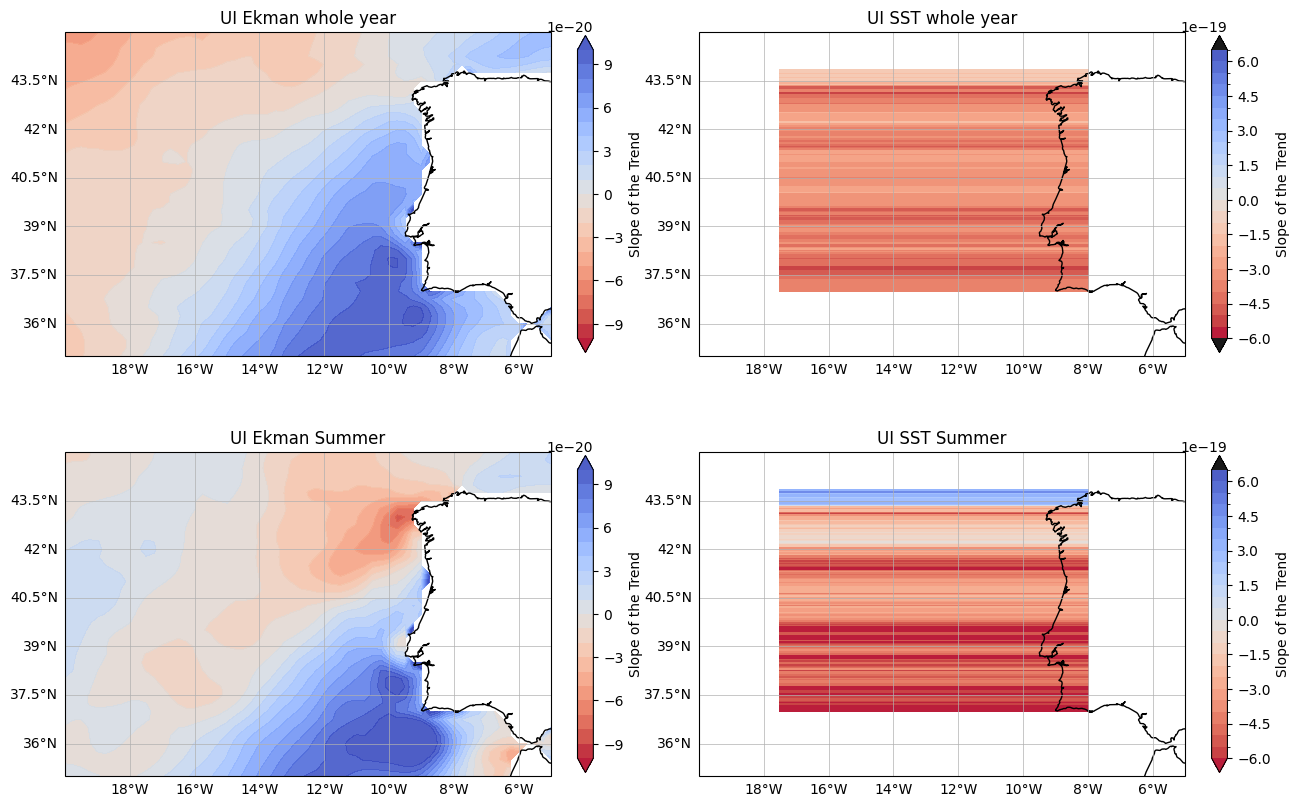

In [237]:
# https://stackoverflow.com/questions/70767908/calculate-linear-trend-in-each-grid-cell
xsize = 2
ysize = 2
fig, axs = plt.subplots(xsize, ysize, figsize = (15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

Vars = [UI_Ek.UI, UI_Ek_summer.UI, UI_SST.UI, UI_SST_summer.UI]
title = ['UI Ekman whole year', 'UI Ekman Summer', 'UI SST whole year', 'UI SST Summer']
i = 0
for x in np.arange(0, xsize):
    for y in np.arange(0, ysize):
        ax = axs[y,x]
        #ax = axs[x]

        # set up cartopy
        ax.set_extent([-20, -5, 45, 35])
        ax.coastlines()
        gls = ax.gridlines(draw_labels=True, linewidth = 0.5)
        gls.top_labels = False 
        gls.right_labels = False

        DS = Vars[i]
        result = DS.polyfit(dim = "time", deg = 1)
        
        if i <= 1:
            
            im = ax.contourf(result.lon, result.lat, result.polyfit_coefficients.sel(degree=1).where(UI_Ek.lsm), 
                         cmap = 'coolwarm_r', levels = np.arange(-1e-19, 1.1e-19, 0.1e-19), extend = 'both', alpha = 0.9)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend')
            
        if i >1:
            im = result.polyfit_coefficients.sel(lon = slice(-20, -5)).sel(degree=1).plot(ax = ax, x = 'lon',
                         cmap = 'coolwarm_r', levels = np.arange(-6e-19, 7e-19, 0.5e-19), alpha = 0.9, add_colorbar=False)
            plt.colorbar(im, fraction = 0.03, label = 'Slope of the Trend', extend = 'both')
    
        ax.set_title(f'{title[i]}')

        i = i+1

(<matplotlib.collections.QuadMesh at 0x7fea07b0da60>,)

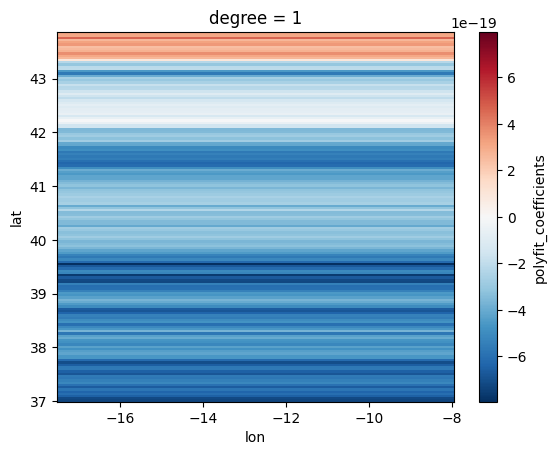

In [210]:
result = UI_SST_summer.UI.polyfit(dim = "time", deg = 1)
#plt.imshow(result.polyfit_coefficients.sel(degree=1))
result.polyfit_coefficients.sel(degree=1).plot(x = 'lon'), 
    #       cmap = 'coolwarm_r', levels = np.arange(-0.6e-19, 1.05e-19, 0.1e-19), extend = 'both', alpha = 0.9)

In [211]:
result

<xarray.Dataset> Size: 89kB
Dimensions:               (lon: 33, lat: 165, degree: 2)
Coordinates:
  * lon                   (lon) float64 264B -15.02 -10.0 -9.77 ... -8.145 -8.02
  * lat                   (lat) float64 1kB 37.01 37.05 37.1 ... 43.8 43.84
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, lon, lat) float64 87kB -7.295e-19 ... -0.6862

In [133]:
UI_Ek_summer['bla'] = np.arange(len(UI_Ek_summer.time)) 

In [155]:
UI_Ek_summer

<xarray.Dataset> Size: 83MB
Dimensions:       (time: 756, lat: 41, lon: 61)
Coordinates:
  * lat           (lat) float64 328B 35.0 35.25 35.5 35.75 ... 44.5 44.75 45.0
  * lon           (lon) float64 488B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
  * time          (time) datetime64[ns] 6kB 1982-06-01 1982-06-08 ... 2023-09-26
Data variables:
    metss         (time, lat, lon) float32 8MB 0.017 0.01607 ... 0.01614 0.0125
    mntss         (time, lat, lon) float32 8MB 0.0006698 -0.0006787 ... 0.0141
    lsm           (lat, lon, time) float64 15MB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    ek_trans_u    (time, lat, lon) float64 15MB 0.007812 -0.007916 ... 0.1334
    ek_trans_v    (time, lat, lon) float64 15MB 0.1983 0.1874 ... 0.1527 0.1182
    wind_stress   (time, lat, lon) float32 8MB 0.01701 0.01608 ... 0.01884
    UI            (time, lat, lon) float64 15MB -0.007812 0.007916 ... -0.1334
    UI_mean       (time) float64 6kB 0.4523 0.379 0.1792 ... -0.3562 0.09221
    week_of_year  (time) float64 6kB 22.0 23.0 24.0 25.0 ... 36.0 37.0 38.0 39.0
    month         (time) object 6kB 'Jun' 'Jun' 'Jun' ... 'Sep' 'Sep' 'Sep'
Attributes:
    Conventions:  CF-1.7
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      2024-04-16T05:35 GRIB to CDM+CF via cfgrib-0.9.9.1/ecCodes-...
    source:       ECMWF

In [164]:
UI_SST_summer

<xarray.Dataset> Size: 94MB
Dimensions:       (time: 720, lon: 33, lat: 165)
Coordinates:
  * lon           (lon) float64 264B -15.02 -10.0 -9.77 ... -8.228 -8.145 -8.02
  * time          (time) datetime64[ns] 6kB 1982-06-01 1982-06-08 ... 2021-09-28
  * lat           (lat) float64 1kB 37.01 37.05 37.1 37.14 ... 43.76 43.8 43.84
Data variables:
    UI            (time, lon, lat) float64 31MB -1.72 -1.89 ... -3.16 -2.74
    Tmid          (time, lon, lat) float64 31MB nan nan nan ... nan nan 289.6
    Toff15W       (time, lon, lat) float64 31MB 290.4 290.5 290.4 ... nan nan
    UI_mean       (time) float64 6kB -1.155 -1.202 -1.073 ... -3.048 -3.504
    week_of_year  (time) float64 6kB 22.0 23.0 24.0 25.0 ... 36.0 37.0 38.0 39.0
    month         (time) object 6kB 'Jun' 'Jun' 'Jun' ... 'Sep' 'Sep' 'Sep'
Attributes: (12/20)
    Conventions:       CF-1.0
    title:             Data
    source:            CoastNet
    institution:       MARE-UL and Greg
    references:        http://geoportal.coastnet.pt
    easting:           lon
    ...                ...
    CoordinateAxes_:   time lon lat
    CoordSysBuilder_:  ucar.nc2.dataset.conv.CF1Convention
    history:           Data extracted from dataset weekly archive available a...
    time:              2080
    lat:               165
    lon:               31